# Download data

In [1]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [2]:
import numpy as np
import pandas as pd
import polars as pl

In [3]:
train_data = pd.read_parquet("data/train_data.parquet")

In [4]:
train_data.shape

(11774752, 101)

In [5]:
val_data = pd.read_parquet("data/validate_data.parquet")

In [6]:
val_data.shape

(639848, 101)

## Data cleaning

In [7]:
# feature selection ## select every feature except 0-4 
# feature_cols = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

In [28]:
from sklearn.preprocessing import MinMaxScaler
ScaleX =    MinMaxScaler(feature_range=(-1,1)).fit(train_data[feature_cols])
ScaleY =    MinMaxScaler(feature_range=(-1,1)).fit(train_data[target_cols])

In [29]:
# the chunk requir maximum memory
X_train =   ScaleX.transform(train_data[feature_cols])
y_train =   ScaleY.transform(train_data[target_cols])
w_train =   train_data[weight_cols]
X_val =     ScaleX.transform(val_data[feature_cols])    
y_val =     val_data[target_cols]
w_val =     val_data[weight_cols]

In [14]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Define the parameters for the XGBRegressor
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'device': 'cuda',          
}

# Create the XGBRegressor model with the specified parameters
model = XGBRegressor(**XGB_Params)

# Fit the model to the training data
model.fit(X_train, y_train,sample_weight=w_train)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
pred = model.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(y_val, pred_inverse, sample_weight=w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.006334


In [18]:
pred_inverse.min(), pred_inverse.max()

(-1.6474009, 5.1243215)

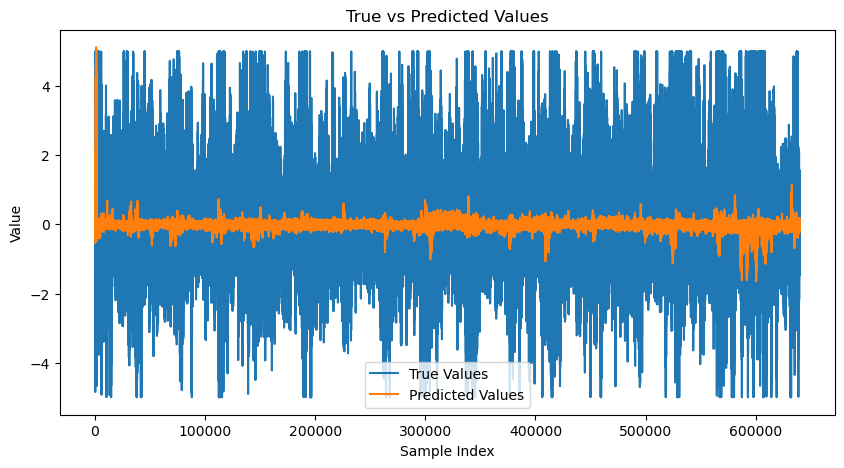

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [26]:
def validate_n_fold(model,X_val, y_val,w_val, n_folds):
    global ScaleY
    batch_size = len(y_val)//n_folds    
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i+batch_size]
        y_batch = y_val[i:i+batch_size]
        w_batch = w_val[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(y_batch, pred_inverse ,sample_weight= w_batch)
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [27]:
validate_n_fold(model,X_val, y_val, w_val, 10)

Batch 0 r2_score: 0.020093
Batch 1 r2_score: 0.006747
Batch 2 r2_score: 0.004269
Batch 3 r2_score: 0.012196
Batch 4 r2_score: -0.000069
Batch 5 r2_score: 0.000166
Batch 6 r2_score: 0.006308
Batch 7 r2_score: 0.003994
Batch 8 r2_score: 0.006539
Batch 9 r2_score: 0.000604
Batch 10 r2_score: -0.915643


# test with train data 8

In [32]:
import joblib
# save
joblib.dump(model, "model/XGBoost.pkl") 
joblib.dump(ScaleX, "model/XGBoost_scaleX.pkl")
joblib.dump(ScaleY, "model/XGBoost_scaleY.pkl")

['model/XGBoost_scaleY.pkl']